In [69]:
from numpy.random.mtrand import choice
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from data_analysis.util import set_ax_pixel_size
from mafia.voting_strategies import *

plt.style.use('ggplot')

typical_tactics = [
    ChancesOfVotingForRedIfRed(0.5),
    ChancesOfVotingForBlackIfRed(0.5),

    ChancesOfVotingForBlackIfBlack(0.5),
    ChancesOfVotingForRedIfBlack(0.5),

    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]
skilled_tactics = [
    ChancesOfVotingForRedIfRed(0.01),
    ChancesOfVotingForBlackIfRed(0.99),

    ChancesOfVotingForBlackIfBlack(0.01),
    ChancesOfVotingForRedIfBlack(0.99),

    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]

gamer_ids = [f'Gamer #{str(g).zfill(2)}' for g in range(30)]

In [70]:
columns = ['g_time', 'g_who_wins', 'g_total_rounds', 'g_when_sheriff_killed', 'p_#', 'gamer_id', 'p_role', 'votes_for_reds', 'votes_for_black']
games_count = 100

df = DataFrame(columns=columns)
for g in range(games_count):
    game = Game()
    chosen_ids = choice(gamer_ids, replace=False, size=10).tolist()

    players_strategies = [[g_id, typical_tactics] for g_id in chosen_ids]
    is_7_in_game = chosen_ids.index('Gamer #07') if 'Gamer #07' in chosen_ids else None
    if is_7_in_game:
        players_strategies[is_7_in_game][1] = skilled_tactics

    game.init_game(players_strategies)
    while True:
        game.commit_night_events()
        if game.the_game_is_over:
            break
        game.commit_day_events()
        if game.the_game_is_over:
            break

    stats = []
    p: Player

    for p in game.players:
        num_of_votes_for_reds = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_red()])
        num_of_votes_for_black = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_maf()])
        stats.append([game.game_time, game.who_wins, game.day_number, game.game_statistics['when_sheriff_killed'], p.number, p.g_id, p.role, num_of_votes_for_reds, num_of_votes_for_black])

    df = pd.concat([df, DataFrame(columns=columns, data=stats)], ignore_index=True)

df['p_is_winner'] = ((df['g_who_wins'] == 'reds') & ((df['p_role'] == 'r') | (df['p_role'] == 's'))) | ( (df['g_who_wins'] == 'maf') & (df['p_role'] == 'm') )
df['p_is_winner'] = df['p_is_winner'].astype('int8')
df

,g_time,g_who_wins,g_total_rounds,g_when_sheriff_killed,p_#,gamer_id,p_role,votes_for_reds,votes_for_black,p_is_winner
0,2023-05-15 10:41:48.085333,maf,4,2,1,Gamer #00,r,0,3,0
1,2023-05-15 10:41:48.085333,maf,4,2,2,Gamer #15,r,3,1,0
2,2023-05-15 10:41:48.085333,maf,4,2,3,Gamer #16,r,1,3,0
3,2023-05-15 10:41:48.085333,maf,4,2,4,Gamer #14,r,0,0,0
4,2023-05-15 10:41:48.085333,maf,4,2,5,Gamer #21,r,0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,2023-05-15 10:41:48.464859,maf,3,0,6,Gamer #07,r,2,2,0
996,2023-05-15 10:41:48.464859,maf,3,0,7,Gamer #08,r,3,1,0
997,2023-05-15 10:41:48.464859,maf,3,0,8,Gamer #09,r,0,2,0
998,2023-05-15 10:41:48.464859,maf,3,0,9,Gamer #16,s,0,0,0


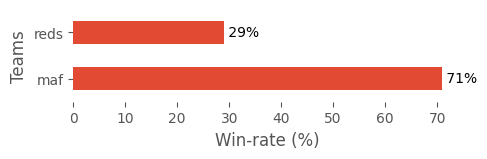

In [71]:
who_wins = df.groupby(['g_time', 'g_who_wins']).agg(wins_count=('g_who_wins', 'count')).reset_index()
who_wins = who_wins.groupby('g_who_wins').agg(wins_by_team=('g_who_wins', 'count')) / len(who_wins) * 100
ax = who_wins.plot(kind='barh', legend=False)
ax.set_frame_on(False)
ax.set_ylabel('Teams')
ax.set_xlabel('Win-rate (%)')
ax.bar_label(ax.containers[0], fmt=' %.0f%%')
set_ax_pixel_size(ax, width=500, height=120)


In [72]:
player_stats = df.groupby('gamer_id').agg(total_games=('gamer_id', 'count'), wins_count=('p_is_winner', 'sum'))
player_stats['win_rate'] = player_stats['wins_count'] / player_stats['total_games'] * 100
player_stats

,total_games,wins_count,win_rate
gamer_id,,,
Gamer #00,28,13,46.428571
Gamer #01,36,12,33.333333
Gamer #02,36,17,47.222222
Gamer #03,35,13,37.142857
Gamer #04,34,12,35.294118
Gamer #05,30,20,66.666667
Gamer #06,32,6,18.750000
Gamer #07,38,20,52.631579
Gamer #08,42,22,52.380952


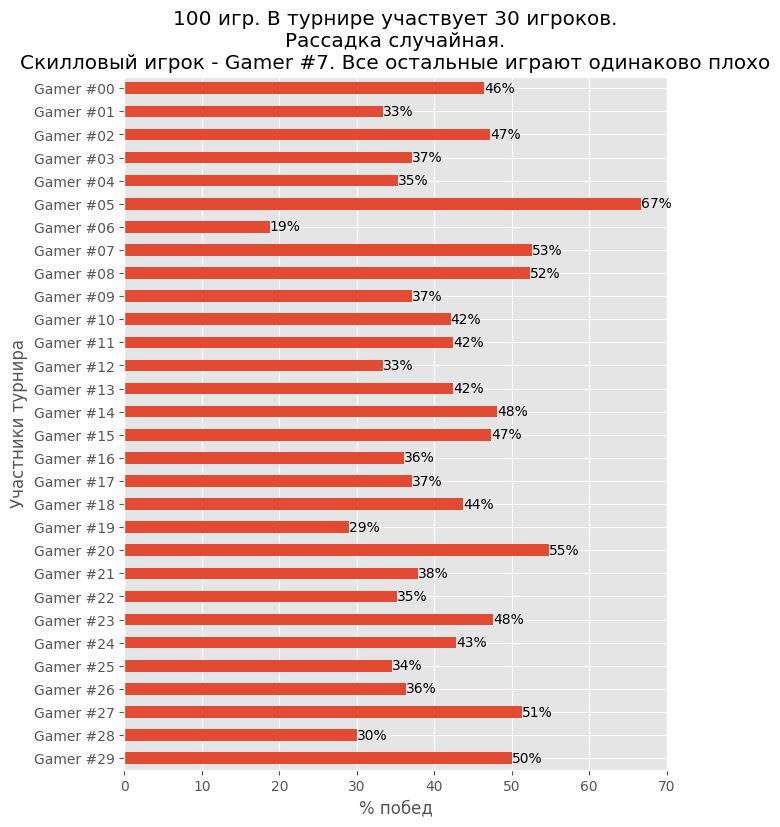

In [73]:
ax = player_stats['win_rate'].plot(kind='barh', legend=False)
set_ax_pixel_size(ax, 700, 900)
ax.bar_label(ax.containers[0], fmt='%.0f%%')
ax.set_ylabel('Участники турнира')
ax.invert_yaxis()
ax.set_xlabel('% побед')
ax.set_title(f'{games_count} игр. В турнире участвует 30 игроков.\nРассадка случайная.\nСкилловый игрок - Gamer #7. Все остальные играют одинаково плохо')
plt.show()

In [74]:
df['correct_votes_cnt'] = (df['votes_for_black'] * ((df['p_role'] == 's') | (df['p_role'] == 'r')).astype('int')) + (df['votes_for_reds'] * (df['p_role'] == 'm').astype('int'))
df

,g_time,g_who_wins,g_total_rounds,g_when_sheriff_killed,p_#,gamer_id,p_role,votes_for_reds,votes_for_black,p_is_winner,correct_votes_cnt
0,2023-05-15 10:41:48.085333,maf,4,2,1,Gamer #00,r,0,3,0,3
1,2023-05-15 10:41:48.085333,maf,4,2,2,Gamer #15,r,3,1,0,1
2,2023-05-15 10:41:48.085333,maf,4,2,3,Gamer #16,r,1,3,0,3
3,2023-05-15 10:41:48.085333,maf,4,2,4,Gamer #14,r,0,0,0,0
4,2023-05-15 10:41:48.085333,maf,4,2,5,Gamer #21,r,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
995,2023-05-15 10:41:48.464859,maf,3,0,6,Gamer #07,r,2,2,0,2
996,2023-05-15 10:41:48.464859,maf,3,0,7,Gamer #08,r,3,1,0,1
997,2023-05-15 10:41:48.464859,maf,3,0,8,Gamer #09,r,0,2,0,2
998,2023-05-15 10:41:48.464859,maf,3,0,9,Gamer #16,s,0,0,0,0


In [75]:
win_and_votes = df.groupby('gamer_id').agg(win_count=('p_is_winner', 'sum'), correct_votes_count=('correct_votes_cnt', 'sum'))
win_and_votes


,win_count,correct_votes_count
gamer_id,,
Gamer #00,13,33
Gamer #01,12,51
Gamer #02,17,58
Gamer #03,13,57
Gamer #04,12,48
Gamer #05,20,42
Gamer #06,6,31
Gamer #07,20,78
Gamer #08,22,48


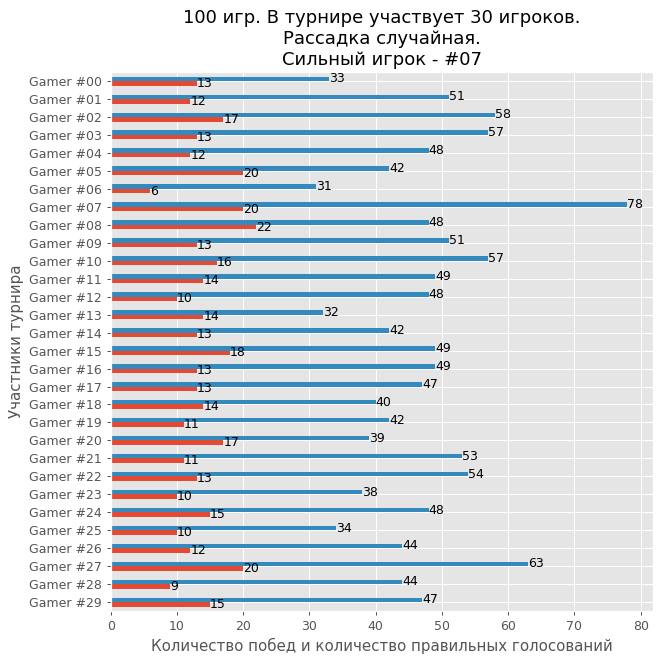

In [76]:
ax = win_and_votes[['win_count', 'correct_votes_count']].sort_index(ascending=False).plot(kind='barh', legend=False)
set_ax_pixel_size(ax, 700, 700, ppi=90)
ax.bar_label(ax.containers[0], fmt='%.0f')
ax.bar_label(ax.containers[1], fmt='%.0f')
ax.set_ylabel('Участники турнира')
ax.set_xlabel('Количество побед и количество правильных голосований')
ax.set_title(f'{games_count} игр. В турнире участвует 30 игроков.\nРассадка случайная.\nСильный игрок - #07')
plt.show()
